# Session 3

### Goals:

1. Generalize previous codebase to multiple data points
2. Introduce torch.nn Module
3. Introduce optimizers
4. Train a linear classifier
5. Train a FFNN

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

import seaborn as sns
import torch

In [2]:
torch.manual_seed(42)

In [3]:
def viz_1d(X, Y, title = None):
    
    if isinstance(Y, torch.Tensor):
        Y = Y.detach()
        
    plt.figure(figsize=(14, 10))
    if title:
        plt.title(title)
    plt.scatter(X, Y)
    plt.show()

def viz_pred(X, Y, Y_, title=None):
    
    if isinstance(Y_, torch.Tensor):
        Y_ = Y_.detach()
        
    plt.figure(figsize=(14, 10))
    if title:
        plt.title(title)
        
    plt.plot(X, Y, 'o')
    plt.plot(X, Y_, '+')
#     plt.scatter(X, Y, color='red')
    plt.show()
    
def viz_all(model, inputs,outputs= None, predictions= None,  ax=None ):
    inputs_scale = (inputs.max()-inputs.min())/10.0
    _X = torch.tensor(np.mgrid[inputs.min()-inputs_scale: inputs.max()+inputs_scale:0.1])
    with torch.no_grad():
        _Y = model(_X).detach()
        
    if ax is None: 
        fig = plt.figure(figsize=(14, 8), dpi=100)
        ax = fig.add_subplot(111)
        old_ax = False
    else:
        old_ax = True
    
    if outputs is not None:
        ax.scatter(inputs, outputs,  c='b', marker="s", label='Y Gold')
    
    if predictions is not None:
        ax.scatter(inputs, predictions, c='r', marker='+', label='Y Pred')
    
    ax.plot(_X, _Y, label='model')
    if not old_ax:
        plt.legend(loc='upper left')
        plt.show()
    

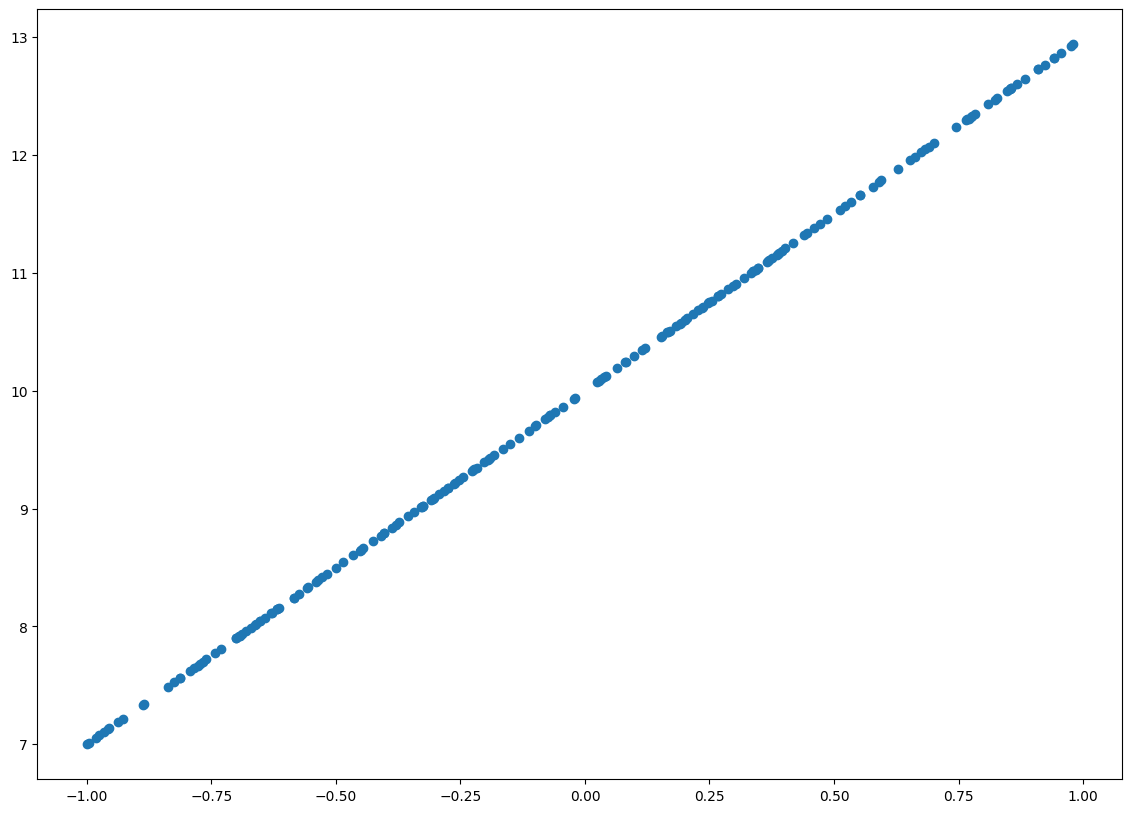

In [4]:

def true_fn(x):
#     return float(x**2 - (x) + 3)
    return float(3*x + 10)


n_samples = 200
X = torch.randint(-400, 400, (n_samples,)).float() / 400
Y = [true_fn(x) for x in X]
Y = torch.tensor(Y)
fx = lambda x : (m*x) + c
viz_1d(X, Y)

In [5]:
# fx = lambda x : (m*x) + c


class LinClf(torch.nn.Module):
    
    def __init__(self,):
        # we declare the params here
        super().__init__()
        
        self.m = torch.nn.Parameter(torch.tensor(0.5))
        self.c = torch.nn.Parameter(torch.tensor(0.1))
        
    def forward(self, inputs):
        # we define 'what to do with params here'
        return (inputs * self.m) + self.c
    

In [6]:
class TwoOrderClf(torch.nn.Module):

    ...
    

In [7]:
# Make model
m = LinClf()
# m = TwoOrderClf()

In [8]:
#  and loss fn
lfn = torch.nn.MSELoss(reduction='sum')

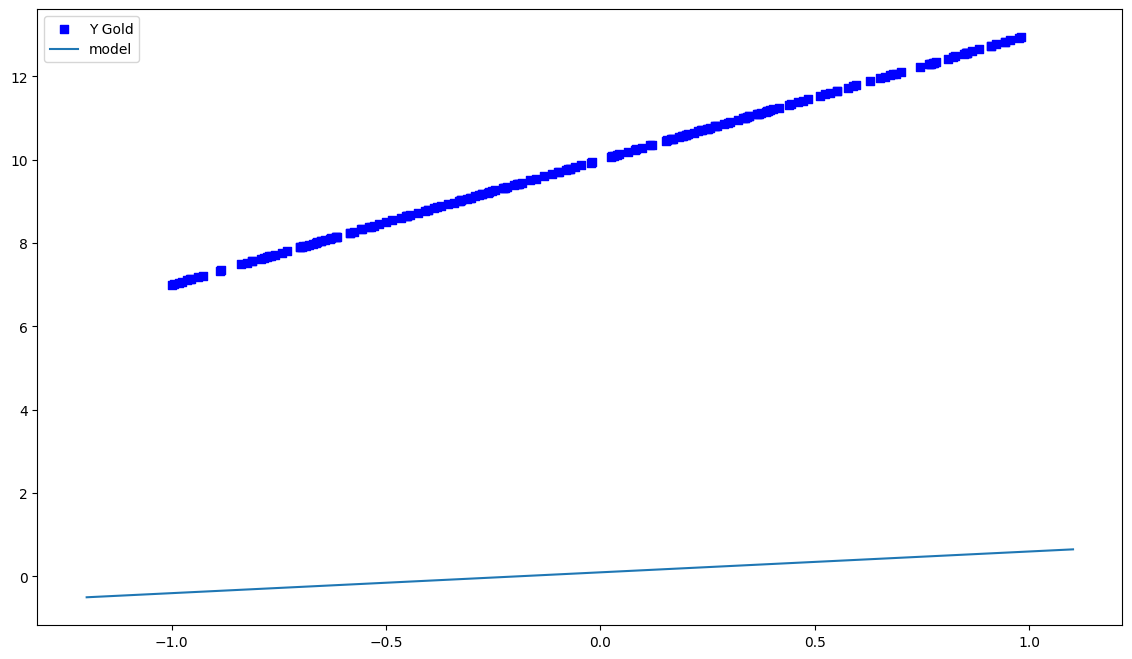

In [9]:
viz_all(m, X, Y)

## Why model class?

- Saving/Loading from Disk
- Setting training mode/evaluation mode
- Easy access to all parameters
- Structure is v. important for complex models
- That is 'pytorch' way!

In [10]:
# Make optimizer
opt = torch.optim.SGD(m.parameters(), lr=0.01)

In [11]:
# See optimizer things (param groups)
opt.param_groups

[{'params': [Parameter containing:
   tensor(0.5000, requires_grad=True),
   Parameter containing:
   tensor(0.1000, requires_grad=True)],
  'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None}]

In [12]:
m, lfn, opt

(LinClf(),
 MSELoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [13]:
epochs = 2000

Parameterres before update:
	m: 2.982074737548828	grad: None
	a2: 9.997994422912598	grad: None
Parameters before update:
	m: 2.9837188720703125	grad: -0.16441819071769714
	a2: 9.998987197875977	grad: -0.09931468963623047
0.0015732378233224154


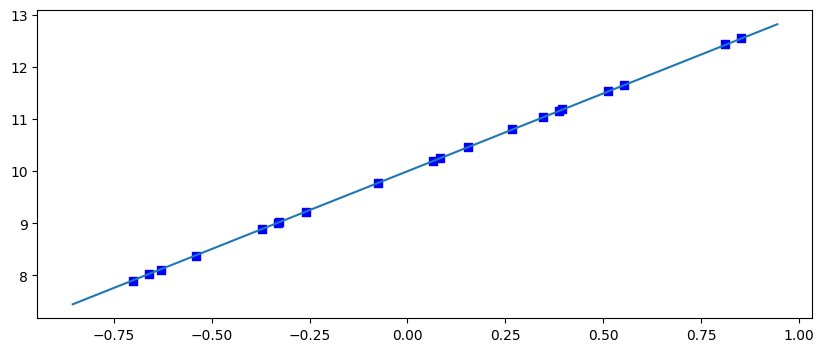

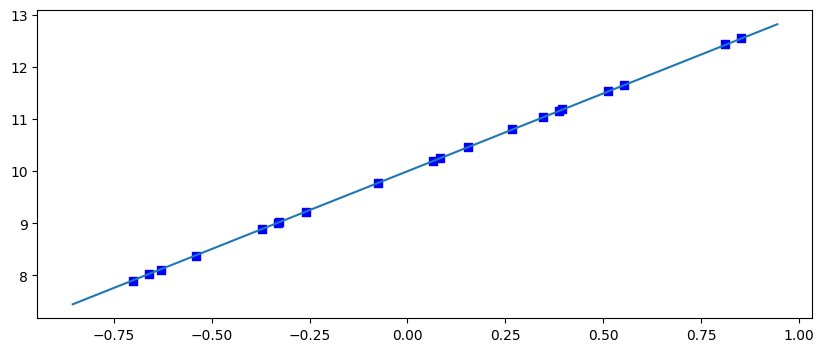

In [14]:

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(111)
# xlim = (-1,2, 1.2)
# ylim = (-1, 14)
# ax1.set_xlim(-1.2, 1.2)
# ax1.set_ylim(-1, 14)
losses = []

# our dataset = X, Y

for e in range(epochs):

    opt.zero_grad() 
    
    # Lets sample a batch
    Xrange = torch.randint(0, n_samples, (20, ))
    _X = X[Xrange]
    _Y = Y[Xrange]
    
    # Make model predictions
    Y_pred = m(_X)
    
    # Calculate Loss
    loss = lfn(Y_pred, _Y)
    
#     print(f"Parameters before update:\n\ta1: {m.a1.item()}\tgrad: {m.a1.grad.item() if m.a1.grad else None}\n\ta2: {m.a2.item()}\tgrad: {m.a2.grad.item() if m.a2.grad else None}\n\t\n\ta1: {m.a3.item()}\tgrad: {m.a3.grad.item() if m.a3.grad else None}")
    print(f"Parameterres before update:\n\tm: {m.m.item()}\tgrad: {m.m.grad.item() if m.m.grad else None}\n\ta2: {m.c.item()}\tgrad: {m.c.grad.item() if m.c.grad else None}")

    # Backpropagate
    loss.backward()
    
    # Update Parameters (m = m - lr*(dL/dm))
    opt.step()
    
#     print(f"Parametrs after update:\n\ta1: {m.a1.item()}\tgrad: {m.a1.grad.item() if m.a1.grad else None}\n\ta2: {m.a2.item()}\tgrad: {m.a2.grad.item() if m.a2.grad else None}\n\t\n\ta1: {m.a3.item()}\tgrad: {m.a3.grad.item() if m.a3.grad else None}")
    print(f"Parameters before update:\n\tm: {m.m.item()}\tgrad: {m.m.grad.item() if m.m.grad else None}\n\ta2: {m.c.item()}\tgrad: {m.c.grad.item() if m.c.grad else None}")
    with torch.no_grad():
        ...
        print(loss.item())
#         ax1.set_xlim(xlim[0], xlim[1])
#         ax1.set_ylim(ylim[0], ylim[1])
        viz_all(model=m, inputs=_X, outputs=_Y, ax=ax1)
#         viz_all(model=m, inputs=_X, outputs=_Y)
        display.display(plt.gcf())

    cmd = input('$: ')
    if cmd.lower().strip() in ['quit', 'q', 'exit', 'stop']:
        break

    plt.cla()
    display.clear_output(wait =True)
    losses.append(loss.item())
        
    if loss.item() < 0.001:
        print('Model fully converged. Stopping.')
#         viz_all(model=m, inputs=X, outputs=Y)
        break

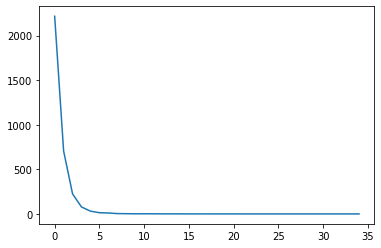

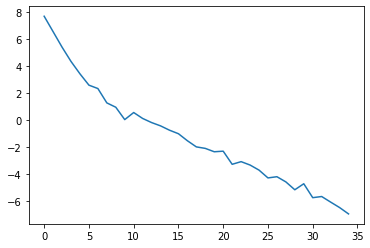

In [52]:
plt.plot(losses)
plt.show()
plt.plot(torch.log(torch.tensor(losses)))
plt.show()